In [29]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
from collections import Counter

In [30]:
in_filename = "data/1.json"
sample_size = 1000

In [31]:
with open(in_filename, 'r') as f:
    data = json.load(f)

In [5]:
ball_id = next(filter(lambda obj: obj['class'] == 'TAGame.Ball_TA', data['class_indices']))
ball_ix = ball_id['index']
print("Ball index:", ball_ix)

Ball index: 65


In [6]:
frames = data['network_frames']['frames']
print("Frame count:", len(frames))

Frame count: 9460


In [7]:
frames[10]

{'time': 12.9685955,
 'delta': 0.0347231,
 'new_actors': [],
 'deleted_actors': [],
 'updated_actors': []}

In [8]:
ball_x = []
ball_y = []

updateids = []
for frame in frames:
    ua = frame['updated_actors']
    uaids = [f['actor_id'] for f in ua]
    updateids += uaids


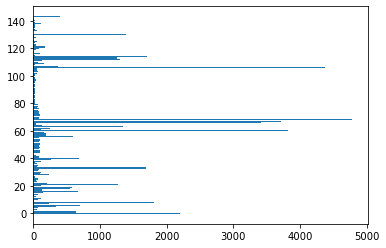

In [9]:
c = Counter(updateids)
plt.barh(list(c.keys()), c.values())
plt.show()

In [10]:
def ix_to_prop(ix, data):
    return data['names'][ix]

In [11]:
for k, ct in c.most_common(10):
    print(f"{ix_to_prop(k, data)} ({k}): {ct}")

VehiclePickup_Boost_TA_0 (68): 4783
CarComponent_DoubleJump_TA_3252 (106): 4371
VehiclePickup_Boost_TA_44 (60): 3821
VehiclePickup_Boost_TA_54 (67): 3708
VehiclePickup_Boost_TA_46 (66): 3410
Ball_TA_365 (0): 2196
Car_TA_3232 (8): 1814
CarComponent_DoubleJump_TA_3253 (114): 1712
Car_TA_3234 (33): 1694
CarComponent_Dodge_TA_3255 (130): 1393


By inspection I am confident that actor_id 66 and 60 are two cars. 68 is probably one of the balls. 0 is also a ball.

## Identify the goal frames

Here we simply pull out the frame number for each of the goals in the replay and
confirm that they look correct. This is useful for cross-checking with our other
tools.

In [12]:
list(filter(lambda n: "Ball" in n, data['names']))

['Ball_TA_365', 'Ball_TA_367', 'Ball_TA_369']

In [13]:
goal_frames = [g['frame'] for g in data['properties']['Goals']]
goal_frames

[2371, 4347]

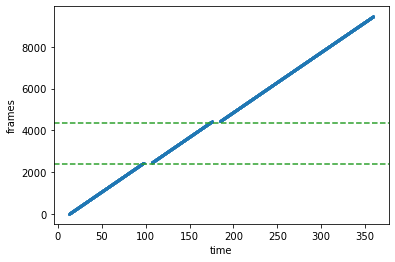

In [14]:
times = [f['time'] for f in frames]
plt.scatter(times, range(len(times)), s=1)
for f in goal_frames:
    plt.axhline(y=f, linestyle='--', c='C2')
plt.xlabel("time")
plt.ylabel("frames")
plt.show()

## Identifying Ball IDs

To easily get ball position throughout the course of the replay, we need to be
able to specify which `updated_actors` are the ball. They have an id, but it's a
bit inscrutable. We were lucky to quickly find out that in this replay,
`actor_id` 0 is the first ball.

In [15]:
id_to_examine = 0
key = 'actor_id'

def isBallActor(updated_actor):
    ball_id = 0
    return (updated_actor['actor_id'] == ball_id and 
        'RigidBody' in updated_actor['attribute'].keys())

outputs = []
for i,f in enumerate(frames):
    ua = f['updated_actors']
    props = list(filter(isBallActor, ua))
    if props:
        #print(props[0])
        outputs.append({'frame': i, 
            'time': f['time'],
            'attribute': props[0]['attribute']
        })

#outputs

So, right, it turns out sometimes there's more than one object in the
`updated_actors` list with the same `actor_id` value. We only want things with
the `RigidBody` property.

In [16]:
ball_locations = []
for f in outputs:
    loc = f['attribute']['RigidBody']['location']
    ball_locations.append(loc)

In [17]:
xs = [obj['x'] for obj in ball_locations]
ys = [obj['y'] for obj in ball_locations]
zs = [obj['z'] for obj in ball_locations]

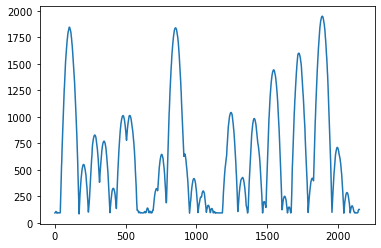

In [18]:
plt.plot(range(len(zs)),zs)
plt.show()

The consistent parabolic movement of this object suggests that it is the ball.

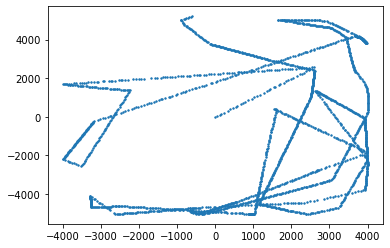

In [19]:
plt.scatter(xs, ys, s=2)
plt.show()

This chart confirms that object 0 is, in fact the ball, but also hints that
there are probably other balls here too, since it doesn't seem to get reset.
Let's look for those indices. I'm still looking for a good way to determine
which indices correspond to the ball. I've found by inspection that 0 and 68 are
ball indices.

In [20]:
id_frequency = []

for i,f in enumerate(frames):
    ua = f['updated_actors']
    for prop in ua:
        if 'RigidBody' in prop['attribute'].keys():
            id_frequency.append({
                'f': i,
                't': f['time'],
                'id': prop['actor_id']
            })

In [21]:
freq = pd.DataFrame.from_records(id_frequency)
freq.head()

,f,t,id
0,0,12.61732,0
1,0,12.61732,8
2,0,12.61732,21
3,0,12.61732,33
4,0,12.61732,35


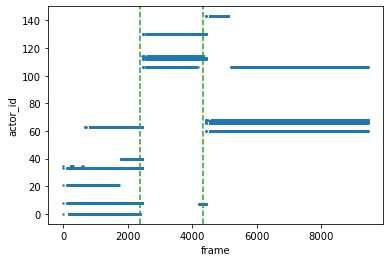

In [22]:
sub_freq = freq.loc[(freq.f < goal_frames[1]) & (freq.f > goal_frames[0])]
sub_freq = freq
plt.scatter(sub_freq.f, sub_freq.id, s=2)
for f in goal_frames:
    plt.axvline(x=f, linestyle='--', c='C2')
plt.xlabel('frame')
plt.ylabel('actor_id')
plt.show()

So this chart shows us the frequency that certain `RigidBody` actors are updated
throughout the replay. This way we can clearly identify the ball and the players
even as their ids change after each goal.

{0: 2151, 33: 992, 8: 989, 63: 696, 21: 690, 40: 257, 35: 22}


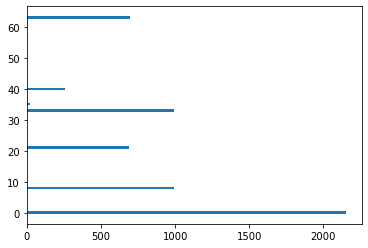

In [23]:
c = dict(Counter(freq.loc[freq.f < goal_frames[0],'id']).most_common())
print(c)
plt.barh(list(c.keys()), c.values())
plt.show()

{68: 4704, 106: 2514, 0: 2151, 67: 2147, 66: 2139, 60: 2138, 114: 1680, 33: 1033, 8: 1032, 113: 827, 130: 823, 112: 807, 63: 738, 21: 690, 40: 298, 143: 254, 7: 95, 35: 22}


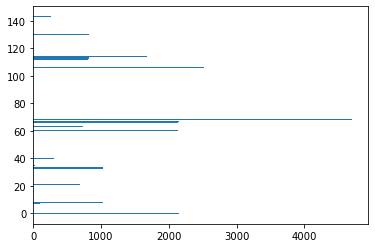

In [24]:
c = dict(Counter(sub_freq.loc[:,'id']).most_common())
print(c)
plt.barh(list(c.keys()), c.values())
plt.show()

That gives us three balls! Is that the right number? It depends on how many goals are in this game.

In [25]:
len(data['properties']['Goals'])

2

Let's make a simplifying assumption here. We can identify the ball ID as: the ID
which is updated the most often within a single point.

In [26]:
def get_updates(data):
    goal_frames = [g['frame'] for g in data['properties']['Goals']]
    frames = data['network_frames']['frames']
    updates = []
    point = 0
    for i,f in enumerate(frames):
        ua = f['updated_actors']
        if i in goal_frames:
            point += 1
        for prop in ua:
            if 'RigidBody' in prop['attribute'].keys():
                updates.append({
                    'f': i,
                    't': f['time'],
                    'pt': point,
                    'id': prop['actor_id'],
                })
    
    return updates

df = pd.DataFrame.from_records(get_updates(data))
df.head()

,f,t,pt,id
0,0,12.61732,0,0
1,0,12.61732,0,8
2,0,12.61732,0,21
3,0,12.61732,0,33
4,0,12.61732,0,35


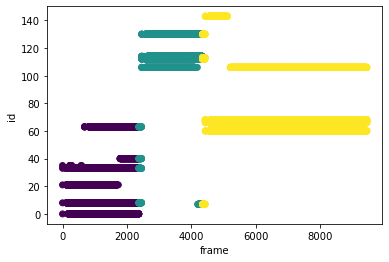

In [27]:
plt.scatter(df.f, df.id, c=df.pt)
plt.xlabel("frame")
plt.ylabel("id")
plt.show()

In [28]:
def identify_objects(update_df):
    # Create a list with n dictionaries
    actor_ids = [{}] * (update_df.pt.max() + 1)

    for pt in range(0, update_df.pt.max() + 1):
        sub = update_df.loc[update_df.pt==pt]
        c = Counter(sub.id).most_common(5)
        actor_ids[pt] = {'ball': c[0][0]}

    return actor_ids

actor_ids = identify_objects(df)


# Retrieving the Ball Locations

In [132]:
def get_ball_info(data):
    ball_ids = [i for i, n in enumerate(data['names']) if "Ball" in n]
    print("Procedural identified ids:", ball_ids)

    ball_ids = [a['ball'] for a in actor_ids]

    frames = data['network_frames']['frames']

    ball_data = []

    def is_ball_actor(updated_actor):
        return (updated_actor['actor_id'] in ball_ids and 
            'RigidBody' in updated_actor['attribute'].keys())

    for i, f in enumerate(frames):
        ua = f['updated_actors']
        if not ua: continue

        ball_prop = [prop for prop in ua if is_ball_actor(prop)]
        if not ball_prop: continue

        assert len(ball_prop) == 1
        ball_prop = ball_prop[0]
        loc = ball_prop['attribute']['RigidBody']['location']
        vel = ball_prop['attribute']['RigidBody']['linear_velocity']
        if vel is None: vel = {'x':0, 'y':0, 'z':0}


        ball_data.append({
            'f': i,
            'ix': ball_prop['actor_id'],
            't': f['time'],
            'x': loc['x'],
            'y': loc['y'],
            'z': loc['z'],
            'dx': vel['x'],
            'dy': vel['y'],
            'dz': vel['z']
        })
    
    return ball_data



In [133]:
ball_data = get_ball_info(data)

Procedural identified ids: [0, 102, 141]


In [134]:
ball_df = pd.DataFrame(ball_data)
ball_df.head()

,f,ix,t,x,y,z,dx,dy,dz
0,0,0,12.617320,0.00,0.00,92.74,0.00,0.00,0.00
1,174,0,18.668650,46.17,44.62,94.89,2098.16,2064.92,123.59
2,175,0,18.703373,116.07,113.40,98.55,2096.00,2062.80,101.79
3,176,0,18.738096,150.99,147.77,100.11,2094.92,2061.74,90.89
4,177,0,18.772820,220.77,216.45,102.69,2092.76,2059.62,69.13


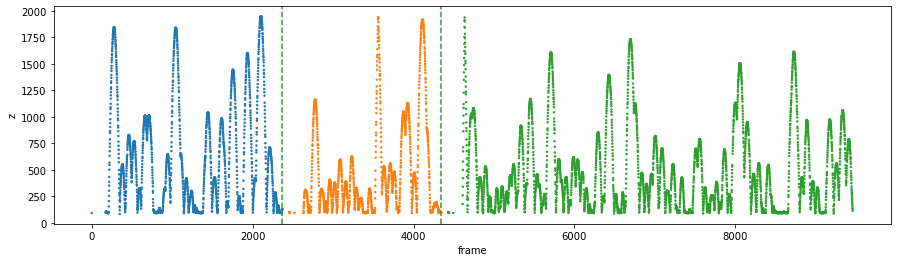

In [136]:
plt.figure(figsize=(15,4))
colors = list(ball_df.ix.map({0:'C0',114:'C1',68:'C2'}))
plt.scatter(ball_df.f, ball_df.z, c=colors, s=2)
for f in goal_frames:
    plt.axvline(x=f, linestyle='--', c='C2')
plt.ylabel('z')
plt.xlabel('frame')
plt.show()

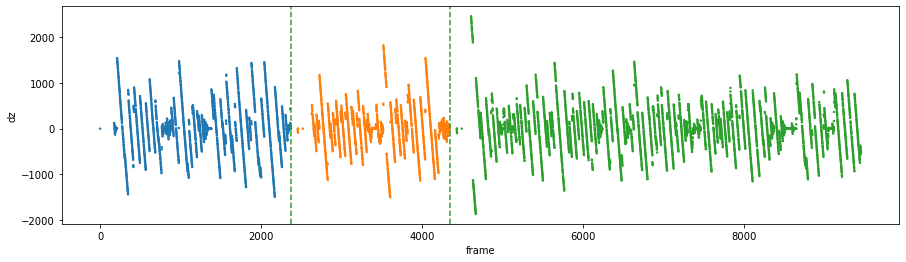

In [137]:
plt.figure(figsize=(15,4))
colors = list(ball_df.ix.map({0:'C0',114:'C1',68:'C2'}))
plt.scatter(ball_df.f, ball_df.dz, c=colors, s=2)
for f in goal_frames:
    plt.axvline(x=f, linestyle='--', c='C2')
plt.xlabel('frame')
plt.ylabel('dz')
plt.show()

Finally, we have a map of the ball's position throughout the match.

These two breaks in the frames are probably the two goals that were scored. The
frames during the goal celebration are not recorded in the replay, which is why
the time axis breaks there.

In [37]:
def search_dict(obj, loc=[]):
    if type(obj) == list:
        for i, el in enumerate(obj):

            if i == 68:
                print(el, loc)
            search_dict(el, loc=loc + [i])
    if type(obj) == dict:
        for k,v in obj.items():
            search_dict(v, loc=loc+[k])
    if obj == 68:
        print("Found @", loc)


In [38]:
temp = data.copy()
temp['network_frames'] = []
search_dict(temp)

TAGame.GameEvent_TA:MatchSettings ['objects']
VehiclePickup_Boost_TA_0 ['names']
Found @ ['net_cache', 6, 'properties', 1, 'object_ind']
Found @ ['net_cache', 20, 'properties', 28, 'stream_id']
{'object_ind': 240, 'stream_id': 108} ['net_cache', 20, 'properties']


If we take the sum of the timestep deltas, we should get the length of the replay.

In [53]:
sum(deltas) / 60

NameError: name 'deltas' is not defined

But there's a `time` property here too which ought to be helpful

In [ ]:
frames[-1]['time'] / 60

KeyError: -1

It seems like this is a different value though.

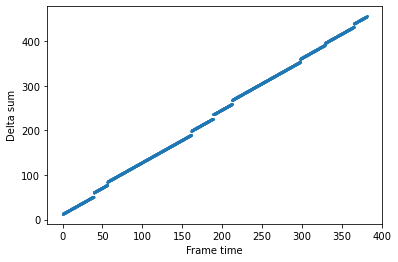

In [ ]:
times = np.cumsum(deltas)
plt.scatter(times, [frame['time'] for frame in data], s=1)
plt.xlabel("Frame time")
plt.ylabel("Delta sum")
plt.show()

These discontinuities might be goals. But we'll need to find out if there's the
right number of them first to determine that.

In [ ]:
with open("data/0.json", 'r') as f:
    raw = json.load(f)

In [ ]:
team1score = raw['header']['body']['properties']['value']['Team1Score']['value']['int']
team0score = raw['header']['body']['properties']['value']['Team0Score']['value']['int']

In [ ]:
frame = data[5214]
with open('data/frame.json', 'w') as f:
    json.dump(frame, f)

In [ ]:
def parse_header(data):
    header = {}
    props = data['header']['body']['properties']['value']
    header['Team0Score'] = props['Team0Score']['value']['int']
    header['Team1Score'] = props['Team1Score']['value']['int']
    header['TeamSize'] = props['TeamSize']['value']['int']
    return header

In [ ]:
parse_header(raw)

{'Team0Score': 1, 'Team1Score': 7, 'TeamSize': 2}

In [ ]:
def parse_frame(frame, header):
    pass